In [ ]:
import os

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
! echo $CUDA_VISIBLE_DEVICES

2


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, trange
from sklearn.metrics import roc_auc_score

import pickle as pkl

#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir="/content/drive/MyDrive/Colab Notebooks/wab")

In [ ]:
path = "/code/CIFAR100"

In [ ]:
pwd

'/code/CIFAR100'

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else{}
print(torch.cuda.is_available()) 

True


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Download data

In [ ]:
batch_size=128

In [ ]:
training_data = datasets.CIFAR100(root='.data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR100(root='.data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set, val_set = torch.utils.data.random_split(training_data,[40000,10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, **LOADER_KWARGS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True, ** LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True, **LOADER_KWARGS)

In [ ]:
training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, **LOADER_KWARGS)

In [ ]:
with open(os.path.join(path, "training_loader.pt"), "wb") as f:
    torch.save(training_loader, f)

with open(os.path.join(path, "test_loader.pt"), "wb") as f:
    torch.save(test_loader, f)


#OOD dataset: SVHN

In [ ]:
svhn_dataset = datasets.SVHN(root='.data', split='test', transform=transforms.ToTensor(), download=True)
svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=batch_size, drop_last=True, **LOADER_KWARGS)

Using downloaded and verified file: .data/test_32x32.mat


# Loading data in drive

In [ ]:
with open(os.path.join(path, "training_loader.pt"), "rb") as f:
  training_loader = torch.load(f)

with open(os.path.join(path, "test_loader.pt"), "rb") as f:
  test_loader = torch.load(f)

In [ ]:
print(training_loader.dataset)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: .data
    Split: Train
    StandardTransform
Transform: ToTensor()


# Network

In [ ]:
eps = 1e-20

In [ ]:
class Gaussian:
  def __init__(self, mu, rho):
    self.mu = mu
    self.rho = rho
    self.normal = torch.distributions.Normal(0,1)
  
  @property
  def sigma(self):
    return torch.log1p(torch.exp(self.rho))
  
  def sample(self):
    epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
    return self.mu + self.sigma * epsilon
  
  def log_prob(self, input):
    return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma+eps) - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [ ]:
class GaussianPrior:
  def __init__(self,mu,sigma):
    self.mu = mu
    self.sigma = sigma
  
  def log_prob(self,input):
    return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma) - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [ ]:
math.log(math.exp(math.sqrt(0.01))-1)

-2.25216846104409

In [ ]:
class BayesianLinear(nn.Module):
  def __init__(self, n_input, n_output, sigma1):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    

    self.w_mu = nn.Parameter(torch.Tensor(n_output,n_input).normal_(0,math.sqrt(2/n_input)))
    self.w_rho = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-2.253,-2.252))
    self.w = Gaussian(self.w_mu, self.w_rho)

    self.b_mu = nn.Parameter(torch.Tensor(n_output).normal_(0,math.sqrt(2/n_input)))
    self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-2.253,-2.252))
    self.b = Gaussian(self.b_mu, self.b_rho)

    #Prior: Gaussian
    self.w_prior = GaussianPrior(0,sigma1)
    self.b_prior = GaussianPrior(0,sigma1)
    self.log_prior = 0 
    self.log_variational_posterior= 0
    self.sigma_mean = 0
    self.sigma_std = 0
  
  def forward(self, input, sample=False):
    if self.training or sample:
      w = self.w.sample()
      b = self.b.sample()
    else:
      w = self.w_mu
      b = self.b_mu
    
    
    self.log_prior = self.w_prior.log_prob(w) + self.b_prior.log_prob(b)
    self.log_variational_posterior = self.w.log_prob(w) + self.b.log_prob(b)
    
    self.sigma_mean = self.w.sigma.mean()
    self.sigma_std = self.w.sigma.std()
    
    
    
    return F.linear(input, w, b)


In [ ]:
class BayesianConv2D(nn.Module):
  def __init__(self, in_channels, out_channels, sigma1, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding

    self.w_mu = nn.Parameter(torch.Tensor(out_channels,in_channels, kernel_size, kernel_size).normal_(0,math.sqrt(2/(out_channels*in_channels*kernel_size*kernel_size))))
    self.w_rho = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-2.253,-2.252))
    self.w = Gaussian(self.w_mu, self.w_rho)
    # check whether bias is needed

    # prior: Gaussian
    self.w_prior = GaussianPrior(0,sigma1)
    self.log_prior = 0
    self.log_variational_posterior = 0

  def forward(self, input, sample=False):
    if self.training or sample:
      w = self.w.sample()
    else:
      w = self.w_mu
    
    self.log_prior = self.w_prior.log_prob(w)
    self.log_variational_porsterior = self.w.log_prob(w) 
    return F.conv2d(input, w, bias=None, stride=self.stride, padding=self.padding)

In [ ]:
def BayesianConv3x3(in_channels, out_channels, sigma1, stride=1):
  return BayesianConv2D(in_channels, out_channels, sigma1, kernel_size=3,stride=stride, padding=1)

In [ ]:
class TLU(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.num_features = num_features
    self.tau = nn.parameter.Parameter(torch.Tensor(1,num_features,1,1), requires_grad=True)
    self.reset_parameters()
  
  def reset_parameters(self):
    nn.init.kaiming_normal_(self.tau)
    
  def forward(self, x):
    return torch.max(x, self.tau)

  

In [ ]:
class FRN(nn.Module):
  def __init__(self, num_features, eps=1e-6, is_eps_learnable=False):
    super().__init__()
    self.num_features = num_features
    self.init_eps = eps
    self.is_eps_learnable = is_eps_learnable

    self.weight = nn.parameter.Parameter(torch.Tensor(1, num_features, 1, 1), requires_grad=True)
    self.bias = nn.parameter.Parameter(torch.Tensor(1,num_features, 1, 1), requires_grad=True)
    if is_eps_learnable:
      self.eps = nn.Parameter(torch.Tensor(1))
    else:
      self.eps = torch.tensor(eps)
    self.reset_parameters()
  
  def reset_parameters(self):
    nn.init.kaiming_normal_(self.weight)
    nn.init.kaiming_normal_(self.bias)
    if self.is_eps_learnable:
      nn.init.constant_(self.eps, self.init_eps)

  def forward(self,x):
    nu2 = x.pow(2).mean(dim=[2,3], keepdim=True)

    x = x * torch.rsqrt(nu2 + self.eps.abs())
    x = self.weight * x + self.bias
    return x

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, sigma1, stride=1, downsample=None):
    super().__init__()
    self.conv1 = BayesianConv3x3(in_channels, out_channels, sigma1, stride)
    self.frn1 = nn.BatchNorm2d(out_channels)
    self.tlu1 = nn.ReLU(inplace=True)
    self.conv2 = BayesianConv3x3(out_channels, out_channels, sigma1)
    self.frn2 = nn.BatchNorm2d(out_channels)
    self.tlu2 = nn.ReLU(inplace=True)
    self.downsample = downsample
    self.log_prior = 0
    self.log_variational_posterior = 0
    self.sigma_mean = 0
    self.sigma_std = 0

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.frn1(out)
    out = self.tlu1(out)
    out = self.conv2(out)
    out = self.frn2(out)
    if self.downsample:
      residual = self.downsample(x)
    out += residual
    out = self.tlu2(out)
    self.log_prior = self.conv1.log_prior + self.conv2.log_prior
    self.log_variational_posterior = self.conv1.log_variational_posterior + self.conv2.log_variational_posterior
    para = torch.cat((self.conv1.w.sigma.flatten(), self.conv2.w.sigma.flatten()))
    self.sigma_mean = para.mean()
    self.sigma_std = para.std()
    return out
  


In [ ]:
class BayesianResNet14(nn.Module):
  def __init__(self, block, sigma1, num_class=10):
    super().__init__()
    self.num_class = num_class

    self.in_channels = 16
    self.conv = BayesianConv3x3(3,16, sigma1)
    self.frn = nn.BatchNorm2d(16)
    self.tlu = nn.ReLU(inplace=True)

    self.block1 = ResidualBlock(16,16,sigma1)
    self.block2 = ResidualBlock(16,16,sigma1)

    downsample1 = nn.Sequential(BayesianConv3x3(16,32,sigma1,2), nn.BatchNorm2d(32))
    self.block3 = ResidualBlock(16,32,sigma1,2,downsample1)
    self.block4 = ResidualBlock(32,32,sigma1)

    downsample2 = nn.Sequential(BayesianConv3x3(32,64,sigma1,2), nn.BatchNorm2d(64))
    self.block5 = ResidualBlock(32,64,sigma1,2,downsample2)
    self.block6 = ResidualBlock(64,64,sigma1)

    self.avg_pool = nn.AvgPool2d(8)
    self.fc = BayesianLinear(64, num_class, sigma1)

  def forward(self, x, sample=False):
    out = self.conv(x)
    out = self.frn(out)
    out = self.tlu(out)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0),-1)
    out = F.softmax(self.fc(out, sample))
    return out
  
  def log_prior(self):
    return self.conv.log_prior + self.block1.log_prior + self.block2.log_prior + self.block3.log_prior + self.block4.log_prior + self.block5.log_prior + self.block6.log_prior + self.fc.log_prior
  
  def log_variational_posterior(self):
    return self.conv.log_variational_posterior + self.block1.log_variational_posterior + self.block2.log_variational_posterior + self.block3.log_variational_posterior + self.block4.log_variational_posterior + self.block5.log_variational_posterior + self.block6.log_variational_posterior + self.fc.log_variational_posterior
  
  
  def free_energy(self, input, target, batch_size, num_batches, n_samples, T):
    outputs = torch.zeros(batch_size, self.num_class).to(DEVICE)
    log_prior = torch.zeros(1).to(DEVICE)
    log_variational_posterior = torch.zeros(1).to(DEVICE)
    negative_log_likelihood = torch.zeros(1).to(DEVICE)
    for i in range(n_samples):
      output = self(input, sample=True)
      outputs +=  output/n_samples
      log_prior += self.log_prior()/n_samples
      log_variational_posterior += self.log_variational_posterior()/n_samples
      negative_log_likelihood += F.nll_loss(torch.log(output+eps), target, size_average=False)/n_samples

    # new target function, not absorb T into prior
    loss = (log_variational_posterior - log_prior / T) + negative_log_likelihood / T * num_batches 

    corrects = outputs.argmax(dim=1).eq(target).sum().item()

    return loss, log_prior, log_variational_posterior, negative_log_likelihood, corrects

  
  

In [ ]:
def write_weight_histograms(epoch):
  writer.add_histogram('histogram/w1_mu', net.l1.w_mu, epoch)
  writer.add_histogram('histogram/w1_rho', net.l1.w_rho, epoch)
  writer.add_histogram('histogram/w2_mu', net.l2.w_mu, epoch)
  writer.add_histogram('histogram/w2_rho', net.l2.w_rho, epoch)
  writer.add_histogram('histogram/w3_mu', net.l3.w_mu, epoch)
  writer.add_histogram('histogram/w3_rho', net.l3.w_rho, epoch)

def write_loss_scalars(epoch, loss, accuracy, log_prior, log_variational_posterior, negative_log_likelihood):
  writer.add_scalar('logs/loss', loss, epoch)
  writer.add_scalar('logs/accuracy', accuracy, epoch)
  writer.add_scalar('logs/complexity', log_variational_posterior-log_prior, epoch)
  writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch)


def write_test_scalar(epoch, loss, accuracy):
  writer.add_scalar('logs/test_loss', loss,epoch)
  writer.add_scalar('logs/test_accuracy', accuracy, epoch)

def write_sigma(epoch):
  writer.add_scalar('sigma/block1', net.block1.sigma_mean,epoch)
  writer.add_scalar('sigma/block2', net.block2.sigma_mean,epoch)
  writer.add_scalar('sigma/block3', net.block3.sigma_mean,epoch)
  writer.add_scalar('sigma/block4', net.block4.sigma_mean,epoch)
  writer.add_scalar('sigma/block5', net.block5.sigma_mean,epoch)
  writer.add_scalar('sigma/block6', net.block6.sigma_mean,epoch)
  writer.add_scalar('sigma/fc', net.fc.sigma_mean,epoch)
  
  writer.add_scalar('sigmastd/block1', net.block1.sigma_std,epoch)
  writer.add_scalar('sigmastd/block2', net.block2.sigma_std,epoch)
  writer.add_scalar('sigmastd/block3', net.block3.sigma_std,epoch)
  writer.add_scalar('sigmastd/block4', net.block4.sigma_std,epoch)
  writer.add_scalar('sigmastd/block5', net.block5.sigma_std,epoch)
  writer.add_scalar('sigmastd/block6', net.block6.sigma_std,epoch)
  writer.add_scalar('sigmastd/fc', net.fc.sigma_std,epoch)


# Train and test


In [ ]:
def train(net, optimizer, epoch, trainLoader, batchSize, nSamples ,T):
  net.train()
  num_batches_train = len(trainLoader)
  
 # if epoch == 0:
  #  write_weight_histograms(epoch)
  for batch_idx, (data, target) in enumerate(tqdm(trainLoader)):
    data, target = data.to(DEVICE), target.to(DEVICE)
    
    net.zero_grad()
    loss, log_prior, log_variational_posterior, negative_log_likelihood, corrects = net.free_energy(data, target, batchSize, num_batches_train, nSamples,T)
    loss.backward()
    optimizer.step()

    accuracy = corrects / batchSize
 # write_loss_scalars(epoch, loss, accuracy, log_prior, log_variational_posterior, negative_log_likelihood)
 # write_weight_histograms(epoch)
  #write_sigma(epoch)
  
  return accuracy, loss

In [ ]:
def test_duringTrain(net, epoch, testLoader, batchSize, nSamples, T, num_class=10):
  net.eval()
  accuracy = 0
  n_corrects = 0
  Loss = 0
  num_batches_test = len(testLoader)
  n_test = batchSize * num_batches_test
  outputs = torch.zeros(n_test, num_class).to(DEVICE)
  correct = torch.zeros(n_test).to(DEVICE)

  
  with torch.no_grad():
    for i, (data, target) in enumerate(testLoader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      for j in range(nSamples):
        output = net(data, sample=True)
        outputs[i*batchSize:batchSize*(i+1), :] += output/nSamples
        Loss +=  F.nll_loss(torch.log(output), target, size_average=False)/nSamples
        # loss is log likelihood
        if j == nSamples - 1:
          correct[i*batch_size:batchSize*(i+1)] = (outputs[i*batchSize:batchSize*(i+1), :]).argmax(1).eq(target)
        
    accuracy = correct.mean()
  #  write_test_scalar(epoch, Loss, accuracy)
    
  return accuracy, Loss

In [ ]:
def test(net, testLoader, batchSize, nSamples,T, num_class=10):
  # update ECE
  net.eval()
  accuracy = 0
  n_corrects = 0
  Loss = 0
  num_batches_test = len(testLoader)
  n_test = batchSize * num_batches_test
  outputs = torch.zeros(n_test, num_class).to(DEVICE)
  correct = torch.zeros(n_test).to(DEVICE)
  target_all = torch.zeros(n_test).to(DEVICE)
  
  M = 10
  boundary = ((torch.tensor(range(0,M))+1)/10).view(1,-1)
  boundary = boundary.repeat(batchSize, 1).to(DEVICE)
  
  acc_Bm_sum = torch.zeros(M).to(DEVICE)
  conf_Bm_sum = torch.zeros(M).to(DEVICE)
  Bm = torch.zeros(M).to(DEVICE)
  
  with torch.no_grad():
    for i, (data, target) in enumerate(testLoader):
      data, target = data.to(DEVICE), target.to(DEVICE)
      target_all[i*batchSize:batchSize*(i+1)] = target
      for j in range(nSamples):
        output = net(data, sample=True)
        outputs[i*batchSize:batchSize*(i+1), :] += output/nSamples
        Loss +=  F.nll_loss(torch.log(output), target, size_average=False)/nSamples
        # loss is log likelihood
        if j == nSamples - 1:
          correct[i*batchSize:batchSize*(i+1)] = (outputs[i*batchSize:batchSize*(i+1), :]).argmax(1).eq(target)
      
      otemp =outputs[i*batchSize:batchSize*(i+1), :]
      p_i,_ = otemp.max(dim=1, keepdims=True)
      B = (p_i.le(boundary)*1).argmax(dim=1)
          
      acc_i = otemp.argmax(1).eq(target)
      for m in range(M):
        is_m = B.eq(m)
        Bm[m] += is_m.sum()
        acc_Bm_sum[m] += torch.sum(acc_i * is_m)
        conf_Bm_sum[m] += torch.sum(p_i.flatten() * is_m)

    accuracy = correct.mean()

  ROCAUC = roc_auc_score(target_all.cpu(), outputs.cpu(), multi_class='ovr')
  
  ECE = (acc_Bm_sum - conf_Bm_sum).abs().sum()/(n_test)

  temp = (acc_Bm_sum - conf_Bm_sum)/Bm
  temp[temp!=temp]=0
  MCE,_ = temp.abs().max(0)

  return accuracy, Loss, ECE, MCE, ROCAUC, output

In [ ]:
def cal_entropy(p):
  logP = p.clone()
  logP[p==0]=1
  logP = torch.log(logP)
  return (-logP*p).sum(dim=1)

def OOD_test(net, oodLoader, inDis_output, batchSize, nSamples, T, num_class=10):
  net.eval()
  num_batches_test = len(oodLoader)
  n_test = batchSize * num_batches_test
  n_inDis = len(inDis_output)

  outputs = torch.zeros(n_test, num_class).to(DEVICE)
  
  target_all = torch.zeros(n_test+n_inDis)
  target_all[n_test:] = 1
  
  score1 = torch.zeros(n_test+n_inDis)
  score2 = torch.zeros(n_test+n_inDis)
  
    
  with torch.no_grad():
    for i, (data, target) in enumerate(oodLoader):
      data = data.to(DEVICE)

      for j in range(nSamples):
        output = net(data,sample=True)
        outputs[i*batch_size:batchSize*(i+1), :] += output/nSamples
  entropy = cal_entropy(outputs)
  entropy_ave = entropy.mean()
  entropy_std = entropy.std()

  score1[:n_test],_ = outputs.max(dim=1)
  score1[n_test:],_ = inDis_output.max(dim=1)

  score2[:n_test] = -1*entropy_ave
  score2[n_test:] = -1*cal_entropy(inDis_output).mean()

  L2D  = (torch.square(outputs-0.1).sum(dim=1)).mean()
  ROCAUC1 = roc_auc_score(target_all, score1, multi_class='ovr', average='weighted')
  ROCAUC2 = roc_auc_score(target_all, score2, multi_class='ovr', average='weighted')
  return entropy_ave, entropy_std, L2D, ROCAUC1, ROCAUC2

# PreTrained Model

In [ ]:
# nonBayesian Network
class myLinear(nn.Module):
  def __init__(self, n_input, n_output, sigma1):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    #self.T = T
    #self.sigma1 = sigma1

    self.w_mu = nn.Parameter(torch.Tensor(n_output,n_input).normal_(0,math.sqrt(2/n_input))) #todo
    

    self.b_mu = nn.Parameter(torch.Tensor(n_output).normal_(0,math.sqrt(2/n_input)))
    
  def forward(self, input, sample=False):
    
    w = self.w_mu
    b = self.b_mu
    
  
    return F.linear(input, w, b)

class myConv2D(nn.Module):
  def __init__(self, in_channels, out_channels, sigma1, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding

    self.w_mu = nn.Parameter(torch.Tensor(out_channels,in_channels, kernel_size, kernel_size))
    self.reset_para()
  
  def reset_para(self):
    nn.init.kaiming_uniform_(self.w_mu, a=math.sqrt(5))
  
  def forward(self, input, sample=False):
    
    w = self.w_mu
    
    
    return F.conv2d(input, w, bias=None, stride=self.stride, padding=self.padding)


def myConv3x3(in_channels, out_channels, sigma1, stride=1):
  return myConv2D(in_channels, out_channels, sigma1, kernel_size=3,stride=stride, padding=1)


class myResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, sigma1, stride=1, downsample=None):
    super().__init__()
    self.conv1 = myConv3x3(in_channels, out_channels, sigma1, stride)
    self.frn1 = nn.BatchNorm2d(out_channels)
    self.tlu1 = nn.ReLU(inplace=True)
    self.conv2 = myConv3x3(out_channels, out_channels, sigma1)
    self.frn2 = nn.BatchNorm2d(out_channels)
    self.tlu2 = nn.ReLU(inplace=True)
    self.downsample = downsample
  
  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.frn1(out)
    out = self.tlu1(out)
    out = self.conv2(out)
    out = self.frn2(out)
    if self.downsample:
      residual = self.downsample(x)
    out += residual
    out = self.tlu2(out)
    return out
  
class myResNet14(nn.Module):
  def __init__(self, sigma1, num_class=10):
    super().__init__()
    self.in_channels = 16
    self.conv = myConv3x3(3,16, sigma1)
    self.frn = nn.BatchNorm2d(16)
    self.tlu = nn.ReLU(inplace=True)

    self.block1 = myResidualBlock(16,16,sigma1)
    self.block2 = myResidualBlock(16,16,sigma1)

    downsample1 = nn.Sequential(myConv3x3(16,32,sigma1,2), nn.BatchNorm2d(32))
    self.block3 = myResidualBlock(16,32,sigma1,2,downsample1)
    self.block4 = myResidualBlock(32,32,sigma1)

    downsample2 = nn.Sequential(myConv3x3(32,64,sigma1,2), nn.BatchNorm2d(64))
    self.block5 = myResidualBlock(32,64,sigma1,2,downsample2)
    self.block6 = myResidualBlock(64,64,sigma1)

    self.avg_pool = nn.AvgPool2d(8)
    self.fc = myLinear(64, num_class, sigma1)

  def forward(self, x, sample=False):
    out = self.conv(x)
    out = self.frn(out)
    out = self.tlu(out)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0),-1)
    out = F.softmax(self.fc(out, sample))
    return out
  
   
  
  def free_energy(self, input, target, batch_size, num_batches, n_samples, T):
    negative_log_likelihood = torch.zeros(1).to(DEVICE)
    for i in range(n_samples):
      output = self(input, sample=True)
      negative_log_likelihood += F.nll_loss(torch.log(output+eps), target, size_average=False)/n_samples

    # new target function, not absorb T into prior
    loss = negative_log_likelihood / T * num_batches 

    corrects = output.argmax(dim=1).eq(target).sum().item()

    return loss, corrects,0,0,0



In [ ]:
pretrained_net = myResNet14(1,num_class=100).to(DEVICE)
with open(os.path.join(path, "trained_netwab100.pkl"), "rb") as f:
      pretrained_net.load_state_dict (torch.load(f))

In [ ]:
testAcc, testLoss, testECE1, testMCE1, AUCROC1, output = test(pretrained_net, test_loader, batch_size, 10, 1, num_class=100)

/tmp/ipykernel_3988/47708021.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc(out, sample))
/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
testAcc

tensor(0.4627, device='cuda:0')

# Basic setting of Network

In [ ]:
# hyperparameter lists
T_list = torch.pow(10,-1*torch.tensor(range(0,35,5))/10).to(DEVICE)
sigma_list = torch.tensor([0.2,0.4,0.8,1]).to(DEVICE)

n_samples = 1

train_accuracy = torch.zeros([7,5]).to(DEVICE)
train_loss = torch.zeros([7,5]).to(DEVICE)

testECE = torch.zeros([7,5]).to(DEVICE)
testMCE = torch.zeros([7,5]).to(DEVICE)
test_accuracy = torch.zeros([7,5]).to(DEVICE)
test_loss = torch.zeros([7,5]).to(DEVICE)
test_ROCAUC = torch.zeros([7,5]).to(DEVICE)
entropy_ave = torch.zeros([7,5]).to(DEVICE)
entropy_std = torch.zeros([7,5]).to(DEVICE)
L2D = torch.zeros([7,5]).to(DEVICE)
ood_ROCAUC1 = torch.zeros([7,5]).to(DEVICE)
ood_ROCAUC2 = torch.zeros([7,5]).to(DEVICE)

In [ ]:
def update_lr(optimizer,lr):
  for param_group in optimizer.param_groups:
    param_group['lr']= lr

In [ ]:
T_list

tensor([1.0000, 0.3162, 0.1000, 0.0316, 0.0100, 0.0032, 0.0010],
       device='cuda:0')

In [ ]:
def reset_net(net, pretrained_net):
  net.conv.w_mu.data.copy_(pretrained_net.conv.w_mu.data)
  net.block1.conv1.w_mu.data.copy_(pretrained_net.block1.conv1.w_mu.data)
  net.block1.conv2.w_mu.data.copy_(pretrained_net.block1.conv2.w_mu.data)
  net.block2.conv1.w_mu.data.copy_(pretrained_net.block2.conv1.w_mu.data)
  net.block2.conv2.w_mu.data.copy_(pretrained_net.block2.conv2.w_mu.data)
  net.block3.conv1.w_mu.data.copy_(pretrained_net.block3.conv1.w_mu.data)
  net.block3.conv2.w_mu.data.copy_(pretrained_net.block3.conv2.w_mu.data)
  net.block4.conv1.w_mu.data.copy_(pretrained_net.block4.conv1.w_mu.data)
  net.block4.conv2.w_mu.data.copy_(pretrained_net.block4.conv2.w_mu.data)
  net.block5.conv1.w_mu.data.copy_(pretrained_net.block5.conv1.w_mu.data)
  net.block5.conv2.w_mu.data.copy_(pretrained_net.block5.conv2.w_mu.data)
  net.block6.conv1.w_mu.data.copy_(pretrained_net.block6.conv1.w_mu.data)
  net.block6.conv2.w_mu.data.copy_(pretrained_net.block6.conv2.w_mu.data)
  net.fc.w_mu.data.copy_(pretrained_net.fc.w_mu.data)
  net.fc.b_mu.data.copy_(pretrained_net.fc.b_mu.data)
  return net

In [ ]:
sigma_list = torch.tensor([0.2,0.4,0.6,0.8,1]).to(DEVICE)

In [ ]:
sigma_list

tensor([0.2000, 0.4000, 0.6000, 0.8000, 1.0000], device='cuda:0')

In [ ]:
epochs = 300
for j,sigma in enumerate(sigma_list):
    for i,T in enumerate(T_list):
        net = BayesianResNet14(ResidualBlock, sigma, num_class=100).to(DEVICE)
        max_lr = 0.0001
        curr_lr = 0.0001
        optimizer = optim.Adam(net.parameters(),lr=curr_lr)
        net = reset_net(net, pretrained_net)
        for epoch in range(epochs):
          train_accuracy[i,j], train_loss[i,j] = train(net, optimizer, epoch, training_loader, batch_size, n_samples,T)
          curr_lr = max_lr/2 * (1+math.cos((epoch)/epochs*math.pi))
          update_lr(optimizer,curr_lr)

        with open(os.path.join(path, f"nets/net{i}{j}.pkl"), "wb") as f:
          torch.save(net.state_dict(), f)

        test_accuracy[i,j], test_loss[i,j], testECE[i,j], testMCE[i,j], test_ROCAUC[i,j], inDis_output = test(net, test_loader, batch_size, 10, T, num_class=100)
        entropy_ave[i,j], entropy_std[i,j], L2D[i,j], ood_ROCAUC1[i,j], ood_ROCAUC2[i,j] = OOD_test(net, svhn_loader, inDis_output, batch_size, 10, T, num_class=100)


    with open(os.path.join(path,"results/train_accuracy.pt"), "wb") as f:
      torch.save(train_accuracy.cpu(),f)

    with open(os.path.join(path, "results/train_loss.pt"), "wb") as f:
      torch.save(train_loss.cpu(),f)

    with open(os.path.join(path, "results/test_accuracy.pt"), "wb") as f:
      torch.save(test_accuracy.cpu(),f)

    with open(os.path.join(path,"results/test_loss.pt"), "wb") as f:
      torch.save(test_loss.cpu(),f)

    with open(os.path.join(path,"results/testECE.pt"), "wb") as f:
      torch.save(testECE.cpu(),f)

    with open(os.path.join(path,"results/testMCE.pt"), "wb") as f:
      torch.save(testMCE.cpu(),f)

    with open(os.path.join(path,"results/entropy_ave.pt"), "wb") as f:
      torch.save(entropy_ave.cpu(),f)

    with open(os.path.join(path,"results/entropy_std.pt"), "wb") as f:
      torch.save(entropy_std.cpu(),f)

    with open(os.path.join(path,"results/L2D.pt"), "wb") as f:
      torch.save(L2D.cpu(),f)

    with open(os.path.join(path,"results/test_ROCAUC.pt"), "wb") as f:
      torch.save(test_ROCAUC.cpu(),f)

    with open(os.path.join(path,"results/ood_ROCAUC1.pt"), "wb") as f:
      torch.save(ood_ROCAUC1.cpu(),f)

    with open(os.path.join(path,"results/ood_ROCAUC2.pt"), "wb") as f:
      torch.save(ood_ROCAUC2.cpu(),f)

  0%|                                                   | 0/390 [00:00<?, ?it/s]/tmp/ipykernel_7483/1559113692.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(self.fc(out, sample))
/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 19%|████████▏                                 | 76/390 [00:05<00:21, 14.69it/s]

In [ ]:
import pandas as pd

In [ ]:
sigma_list = [r'$\sigma_0=0.2$',r'$\sigma_0=0.4$',r'$\sigma_0=0.6$',r'$\sigma_0=0.8$',r'$\sigma_0=1$']
T_list = ['1',r'$10^{-0.5}$',r'$10^{-1}$',r'$10^{-1.5}$',r'$10^{-2}$',r'$10^{-2.5}$',r'$10^{-3}$']

In [ ]:
testAcc_df = pd.DataFrame(test_accuracy.numpy(),index=T_list,columns=sigma_list)
testLoss_df = pd.DataFrame(test_loss.numpy(),index=T_list,columns=sigma_list)
trainAcc_df = pd.DataFrame(train_accuracy.numpy(),index=T_list,columns=sigma_list)
testECE_df = pd.DataFrame(testECE.numpy(),index=T_list,columns=sigma_list)
testMCE_df = pd.DataFrame(testMCE.numpy(),index=T_list,columns=sigma_list)
L2D_df = pd.DataFrame(L2D.numpy(),index=T_list,columns=sigma_list)
entAve_df = pd.DataFrame(entropy_ave.numpy(),index=T_list,columns=sigma_list)
entStd_df = pd.DataFrame(entropy_std.numpy(),index=T_list,columns=sigma_list)
test_ROCAUC_df = pd.DataFrame(test_ROCAUC.numpy(),index=T_list,columns=sigma_list)
ood_ROCAUC_df = pd.DataFrame(ood_ROCAUC1.numpy(),index=T_list,columns=sigma_list)

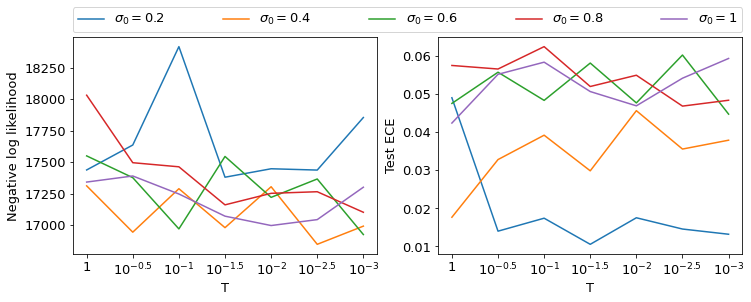

In [ ]:
f= plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(testLoss_df)
#ax1.legend(sigma_list)
ax1.set_xlabel('T')
ax1.set_ylabel('Negative log likelihood')
ax2.plot(testECE_df)
ax2.legend(sigma_list,bbox_to_anchor=(-1.2,1.02,2.2,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5)
ax2.set_xlabel('T')
ax2.set_ylabel('Test ECE')
plt.rcParams.update({'font.size': 13})
plt.savefig('./cifar100ID.jpg', bbox_inches='tight')
plt.show()


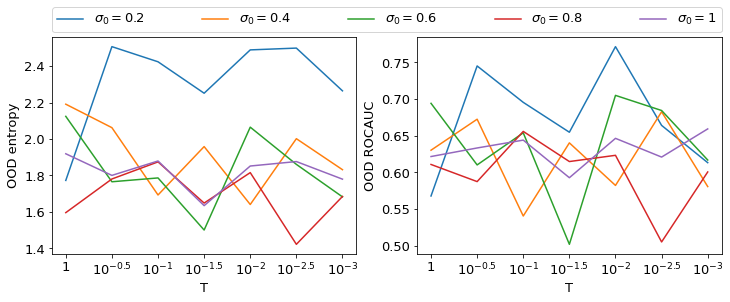

In [ ]:
f= plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(entAve_df)
#ax1.legend(sigma_list)
ax1.set_xlabel('T')
ax1.set_ylabel('OOD entropy')
ax2.plot(ood_ROCAUC_df)
ax2.legend(sigma_list,bbox_to_anchor=(-1.2,1.02,2.2,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5)
ax2.set_xlabel('T')
ax2.set_ylabel('OOD ROCAUC')
plt.rcParams.update({'font.size': 13})
plt.savefig('./cifar100OOD.jpg', bbox_inches='tight')
plt.show()
